# GETTING STARTED
This is interactive code, which runs sequentially in cells. 
You can run each cell independently or run everything all at once.

You cannot run a cell without running the cells above it or it will have errors.

To run everything at once:
- Go to the 'Run' menu at the top
- Tap 'Run All Cells'
- Click [here](#plot_china_nonchina_stocks) to see the fancy chart


### Links

*These links will not work until you 'Run All Cells' as instructed above*

#### Stock info
- [Click here to modify tracked stocks](#stocks)
- [Click here to see the chart with stocks](#plot_china_nonchina_stocks)

#### Other plots
- [Plot Confirmed Cases for China/non-China](#plot_china_nonchina)
- [Plot Confirmed Cases for Top Countries](#plot_top_countries_confirmed)
- [Plot Growth for Top Countries](#plot_top_countries_growth)
- [Plot Acceleration for Top Countries](#plot_top_countries_acceleration)

## Download dataset 

Dataset is at https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/

In [563]:
import pandas as pd
import requests
import io

confirmedUrl = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
deathsUrl = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'

r = requests.post(confirmedUrl)
if r.ok:
    data = r.content.decode('utf8')
    df = pd.read_csv(io.StringIO(data))
    
# Rename Province/State and Country/Region
df = df.rename(columns={'Province/State': 'provincestate', 'Country/Region': 'countryregion'})

# Remove unneeded columns
df = df.drop(['Lat', 'Long', 'provincestate'], axis=1)

# Reshape 
df_confirmed = df.melt(var_name='date', value_name='confirmed', id_vars='countryregion')
df_confirmed['date'] = pd.to_datetime(df_confirmed['date'])

date_min = df_confirmed['date'].min()
date_max = df_confirmed['date'].max()
print('Retrieved results from {} to {}'.format(date_min, date_max))


Retrieved results from 2020-01-22 00:00:00 to 2020-03-17 00:00:00


In [564]:
### Group values by countryregion
df_confirmed_grouped = df_confirmed[['date','countryregion', 'confirmed']].groupby(['date', 'countryregion']).sum()

## Calculate metrics

In [565]:
# Calculate change
window = 5
growthCalculation = lambda x: (x.max())

from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

x = pd.Series(range(0,window)).values.reshape(-1,1)
linearCoefficient = lambda values: (linear_regressor.fit(x, values.values.reshape(-1,1)).coef_)

df_confirmed_grouped = df_confirmed_grouped.reset_index()
df_confirmed_grouped['growth_rate'] = df_confirmed_grouped.groupby(['countryregion'])['confirmed'].rolling(window).apply(linearCoefficient).fillna(0).reset_index(level=0, drop=True)
df_confirmed_grouped['acceleration_rate'] = df_confirmed_grouped['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0)

df_confirmed_grouped.head(10)

,date,countryregion,confirmed,growth_rate,acceleration_rate
0,2020-01-22,Afghanistan,0,0.0,0.0
1,2020-01-22,Albania,0,0.0,0.0
2,2020-01-22,Algeria,0,0.0,0.0
3,2020-01-22,Andorra,0,0.0,0.0
4,2020-01-22,Antigua and Barbuda,0,0.0,0.0
5,2020-01-22,Argentina,0,0.0,0.0
6,2020-01-22,Armenia,0,0.0,0.0
7,2020-01-22,Aruba,0,0.0,0.0
8,2020-01-22,Australia,0,0.0,0.0
9,2020-01-22,Austria,0,0.0,0.0


## Prepare China data for plotting

In [566]:
# Prepare China
df_china = df_confirmed_grouped.query('countryregion == "China"')
df_china_prepared = df_china.groupby('date').sum()

df_china_prepared.head()

,confirmed,growth_rate,acceleration_rate
date,,,
2020-01-22,548,0.0,0.00
2020-01-23,643,0.0,0.00
2020-01-24,920,0.0,0.00
2020-01-25,1406,0.0,0.00
2020-01-26,2075,381.7,76.32


In [567]:
# Convert to tidy format
df_china_prepared = df_china_prepared.reset_index()

df_china_prepared.head()

,date,confirmed,growth_rate,acceleration_rate
0,2020-01-22,548,0.0,0.00
1,2020-01-23,643,0.0,0.00
2,2020-01-24,920,0.0,0.00
3,2020-01-25,1406,0.0,0.00
4,2020-01-26,2075,381.7,76.32


## Prepare non-China data for plotting

In [568]:
# Prepare non-China
# print(df_confirmed_grouped.index.unique(level='countryregion'))
df_non_china = df_confirmed_grouped.query('countryregion != ""')

# Drop growth rate calculations as they were done per country
df_non_china = df_non_china.drop(['growth_rate', 'acceleration_rate'], axis=1)
df_non_china = df_non_china.groupby('date').sum()

df_non_china.head(10)

,confirmed
date,
2020-01-22,555
2020-01-23,653
2020-01-24,941
2020-01-25,1434
2020-01-26,2118
2020-01-27,2927
2020-01-28,5578
2020-01-29,6166
2020-01-30,8234


In [569]:
# Calculate growth again
df_non_china['growth_rate'] = df_non_china['confirmed'].rolling(window).apply(linearCoefficient).fillna(0)
df_non_china['acceleration_rate'] = df_non_china['growth_rate'].rolling(window).apply(linearCoefficient).fillna(0)

print(df_non_china.shape)
df_non_china.head()

(56, 3)


,confirmed,growth_rate,acceleration_rate
date,,,
2020-01-22,555,0.0,0.00
2020-01-23,653,0.0,0.00
2020-01-24,941,0.0,0.00
2020-01-25,1434,0.0,0.00
2020-01-26,2118,390.7,78.14


In [570]:
# Convert to 'tidy' format for plotting
df_non_china_prepared = df_non_china.reset_index()
df_non_china_prepared.head()

,date,confirmed,growth_rate,acceleration_rate
0,2020-01-22,555,0.0,0.00
1,2020-01-23,653,0.0,0.00
2,2020-01-24,941,0.0,0.00
3,2020-01-25,1434,0.0,0.00
4,2020-01-26,2118,390.7,78.14


<a id='stocks'></a>
# Get stock data

In [571]:
# MODIFY THESE TO ADD YOUR STOCKS
stocks_pharma = ['MRNA', 'REGN', 'INO'] #From http://www.marketwatch.com/story/think-twice-before-investing-in-biotech-companies-working-on-coronavirus-treatments-the-odds-of-picking-a-winner-are-low-2020-03-18
stocks_indices = ['SPY', 'AC', 'DJI'] 

# Combine everything
stocks_to_track = stocks_indices + stocks_pharma

In [572]:
import yfinance as yf

def getStockInfo(tickerSymbol, date_min, date_max):
    msft = yf.Ticker(tickerSymbol)
    stocks = msft.history(start=date_min, end=date_max)
    stocks['Ticker'] = tickerSymbol
    stocks['Close % Change'] = stocks['Close'].pct_change().fillna(0)
    return stocks[['Close % Change', 'Ticker']]

from functools import reduce

stocks = pd.concat(map(lambda x: getStockInfo(x, date_min, date_max), stocks_to_track)).reset_index()

stocks.head(200)

,Date,Close % Change,Ticker
0,2020-01-22,0.000000,SPY
1,2020-01-23,0.001147,SPY
2,2020-01-24,-0.008893,SPY
3,2020-01-27,-0.016029,SPY
4,2020-01-28,0.010479,SPY
...,...,...,...
195,2020-02-03,-0.136865,INO
196,2020-02-04,-0.051151,INO
197,2020-02-05,-0.040431,INO
198,2020-02-06,-0.053371,INO


## Plot
### Prepare chart

In [573]:
# Show fig
import plotly.express as px
import plotly.graph_objects as go

colorSequence = ["red", "royalblue"]

layout = go.Layout(title="COVID-19 in China and non-China", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Stock price % change'},                   
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False, 'position': 1},
                   yaxis3={'title': 'Confirmed cases', 
                           "showgrid": False,
                           'overlaying': 'y',
                           'side': 'right',
                           'position': 0.92},
                   xaxis={"title": "Date",
                         'domain': [0, 0.92]},
                   height=1000)

chinaColor = colorSequence[0]
nonChinaColor = colorSequence[1]

# Only plot 'confirmed', since we can't control the dashed lines and second-axes using Plotly Express
trace_confirmed_china = go.Scatter(x=df_china_prepared['date'], 
                                y=df_china_prepared['confirmed'], 
                                name='Confirmed (China)',
                                line=dict(color=chinaColor, 
                                          width=4), 
                                yaxis="y3")

trace_confirmed_non_china = go.Scatter(x=df_non_china_prepared['date'], 
                                y=df_non_china_prepared['confirmed'], 
                                name='Confirmed (non-China)',
                                line=dict(color=nonChinaColor, 
                                          width=4), 
                                yaxis="y3")

# Reset index
df_non_china_flattened = df_non_china.reset_index()

# Add growth rate
trace_growth_china = go.Scatter(x=df_china['date'], 
                                y=df_china['growth_rate'], 
                                name='Growth rate (China)',
                                line=dict(color=chinaColor, 
                                          width=4, 
                                          dash='dash'), 
                                yaxis="y2")
trace_growth_non_china = go.Scatter(x=df_non_china_flattened['date'], 
                                    y=df_non_china_flattened['growth_rate'], 
                                    name='Growth rate (non-China)',
                                    line=dict(color=nonChinaColor, 
                                              width=4, 
                                              dash='dash'), 
                                    yaxis="y2")

# Add acceleration rate
trace_accel_china = go.Scatter(x=df_china['date'], 
                               y=df_china['acceleration_rate'], 
                               name='Accel. rate (China)',
                         line=dict(color=chinaColor, 
                                   width=2, 
                                   dash='dot'), 
                               yaxis="y2")

trace_accel_non_china = go.Scatter(x=df_non_china_flattened['date'], 
                                   y=df_non_china_flattened['acceleration_rate'], 
                                   name='Accel. rate (non-China)',
                         line=dict(color=nonChinaColor, 
                                   width=2, 
                                   dash='dot'), 
                                   yaxis="y2")

traces_stocks = px.line(stocks, 
                           x='Date', 
                           y='Close % Change', 
                           color='Ticker',
                           color_discrete_map=colorMap,).data

<a id='plot_china_nonchina'></a>
### Plot Confirmed Cases for China/non-China

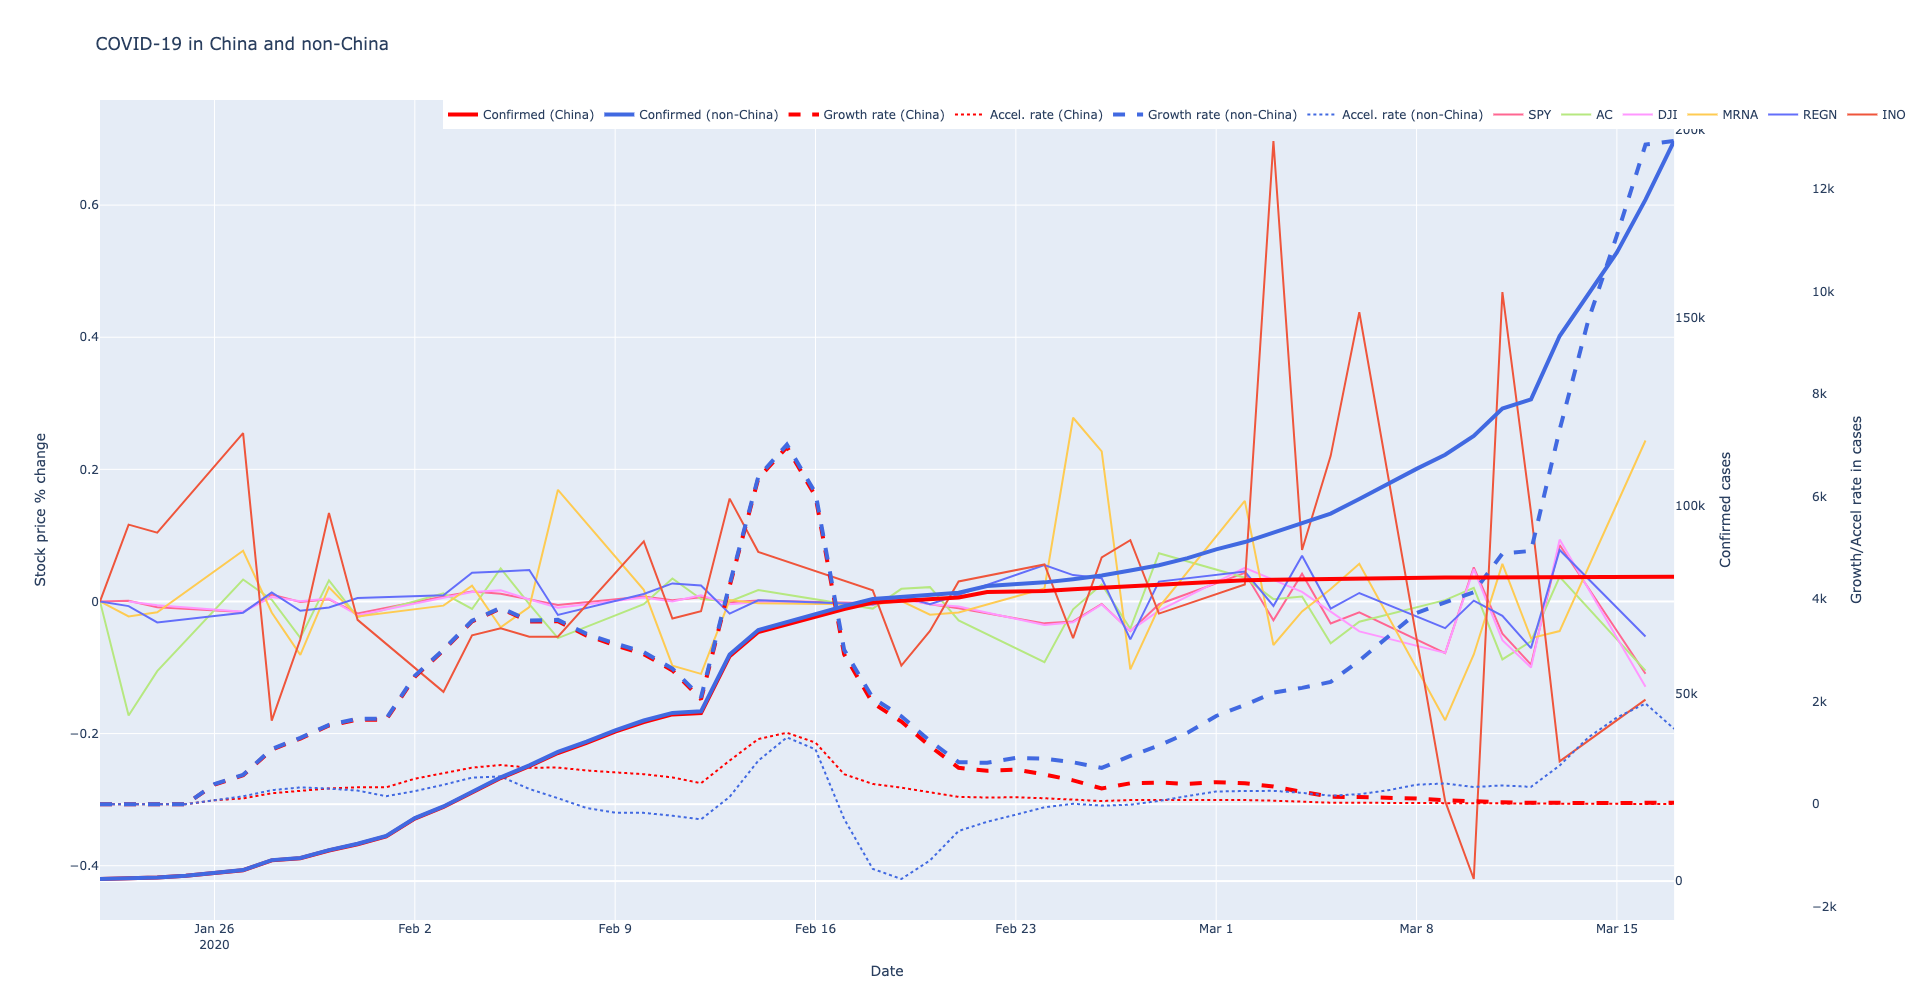

In [574]:
# Combine to make a tuple
traces_combined = (trace_confirmed_china, trace_confirmed_non_china, trace_growth_china, trace_accel_china, trace_growth_non_china, trace_accel_non_china,) + traces_stocks
fig = go.Figure(data=traces_combined, layout=layout)
fig.show()

<a id='plot_china_nonchina_stocks'></a>
### Plot Stocks Against Confirmed Cases for China/non-China

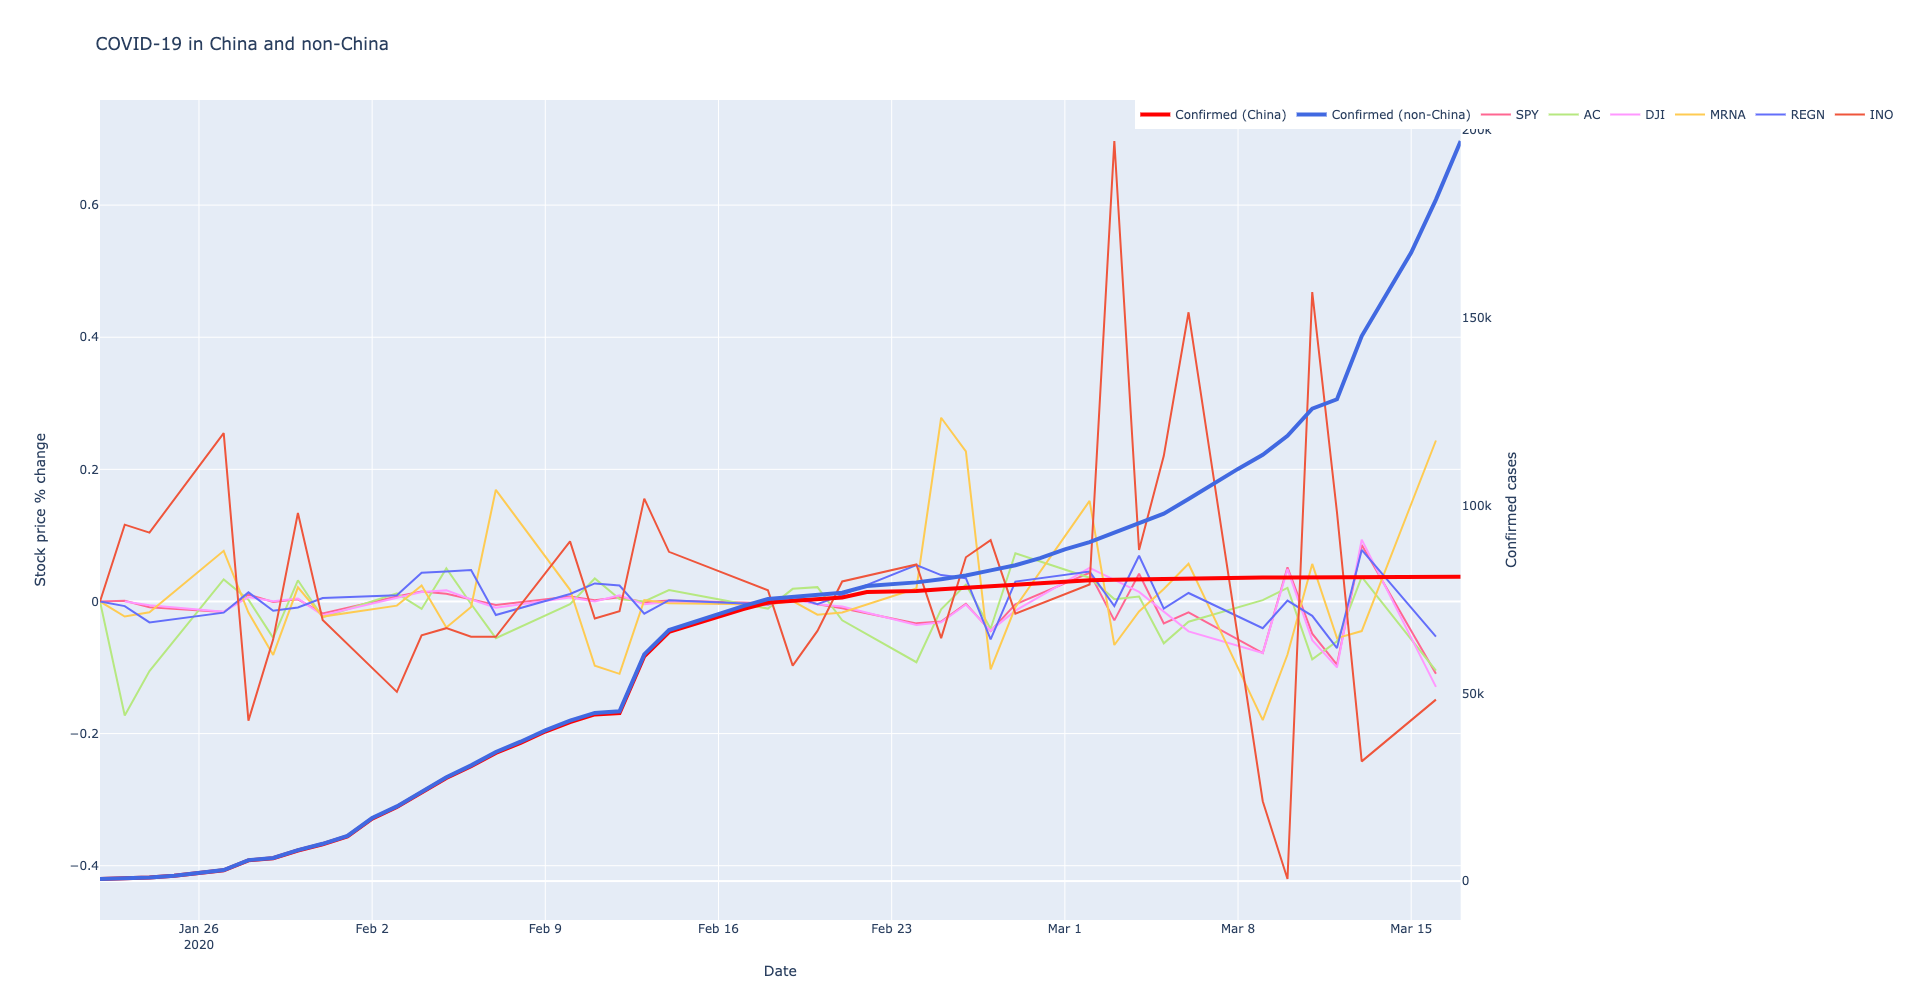

In [575]:
# Combine to make a tuple
traces_combined = (trace_confirmed_china, trace_confirmed_non_china) + traces_stocks
fig = go.Figure(data=traces_combined, layout=layout)
fig.show()

## Prepare top countries for plotting

In [576]:
#Get top ten countries by total cases
df_non_china = df_confirmed_grouped.query('countryregion != "China"')

top_countries_by_total_cases = df_non_china.groupby('countryregion').sum().nlargest(10, 'confirmed').reset_index()['countryregion']
df_non_china_top = df_confirmed_grouped[df_confirmed_grouped.reset_index()['countryregion'].isin(top_countries_by_total_cases)]

df_non_china_top.head()

,date,countryregion,confirmed,growth_rate,acceleration_rate
36,2020-01-22,Cruise Ship,0,0.0,0.0
49,2020-01-22,France,0,0.0,0.0
52,2020-01-22,Germany,0,0.0,0.0
66,2020-01-22,Iran,0,0.0,0.0
70,2020-01-22,Italy,0,0.0,0.0


In [577]:
# Only plot 'confirmed', since we can't control the dashed lines and second-axes using Plotly Express
traces_confirmed = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='confirmed', 
                           color='countryregion').data

# Only plot 'growth'
traces_growth = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='growth_rate', 
                           color='countryregion').data

# Only plot 'acceleration'
traces_acceleration = px.line(pd.concat([df_non_china_top]), 
                           x='date', 
                           y='acceleration_rate', 
                           color='countryregion').data

# traces_combined = traces_confirmed + traces_growth + traces_acceleration

<a id='plot_top_countries_confirmed'></a>
### Plot Confirmed Cases for Top Countries

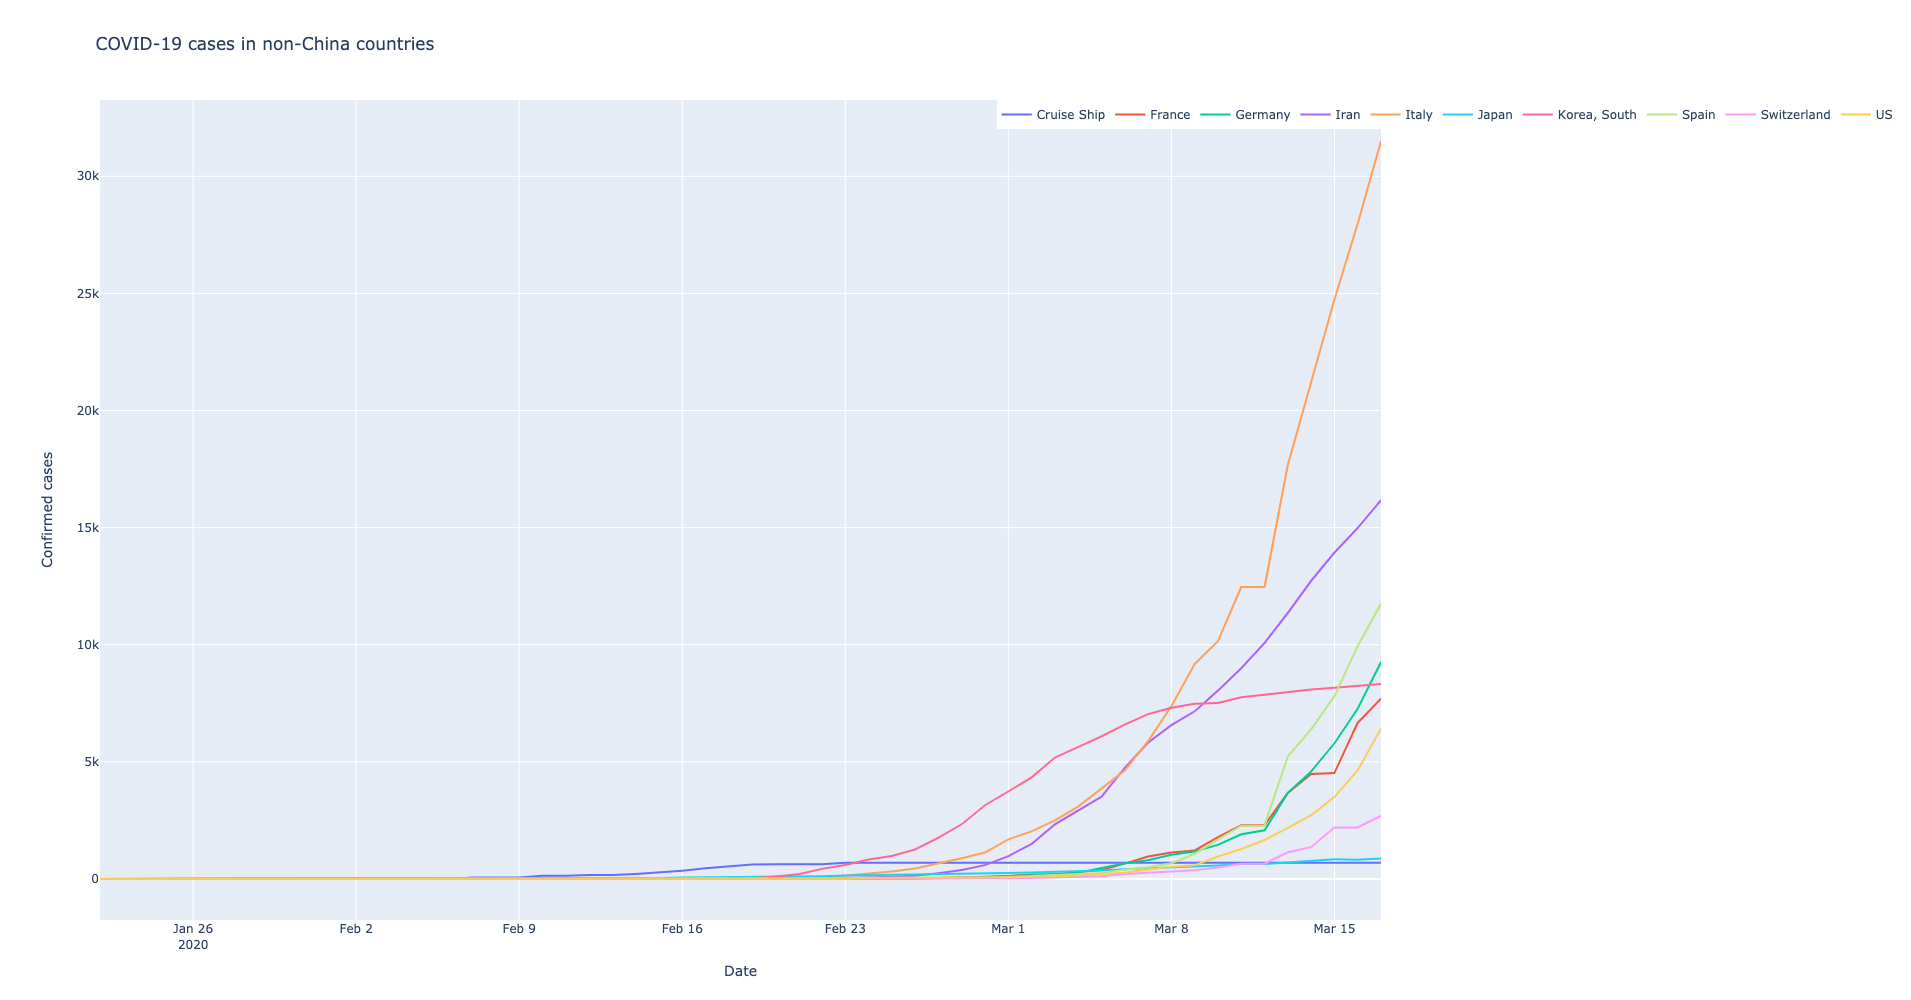

In [578]:
layout = go.Layout(title="COVID-19 cases in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_confirmed, layout=layout)
fig.show()

<a id='plot_top_countries_growth'></a>
### Plot Growth for Top Countries

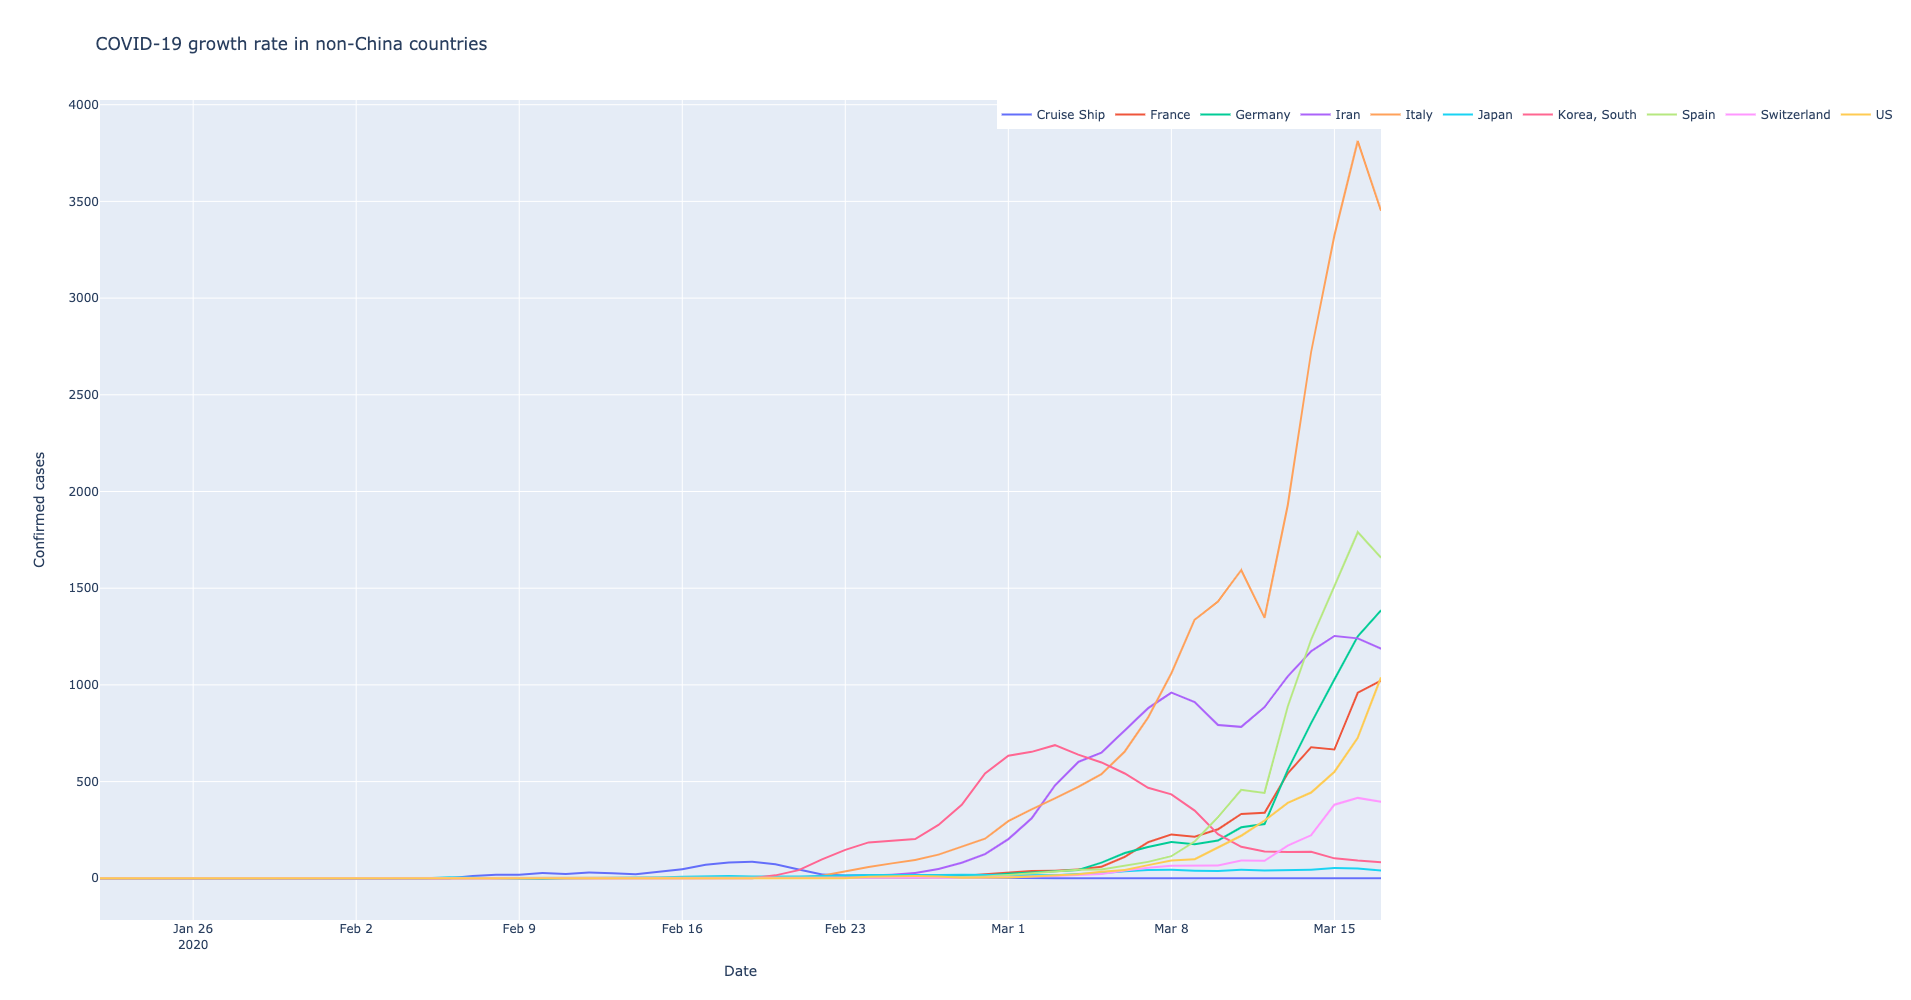

In [579]:
layout = go.Layout(title="COVID-19 growth rate in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_growth, layout=layout)
fig.show()

<a id='plot_top_countries_acceleration'></a>
### Plot Acceleration for Top Countries

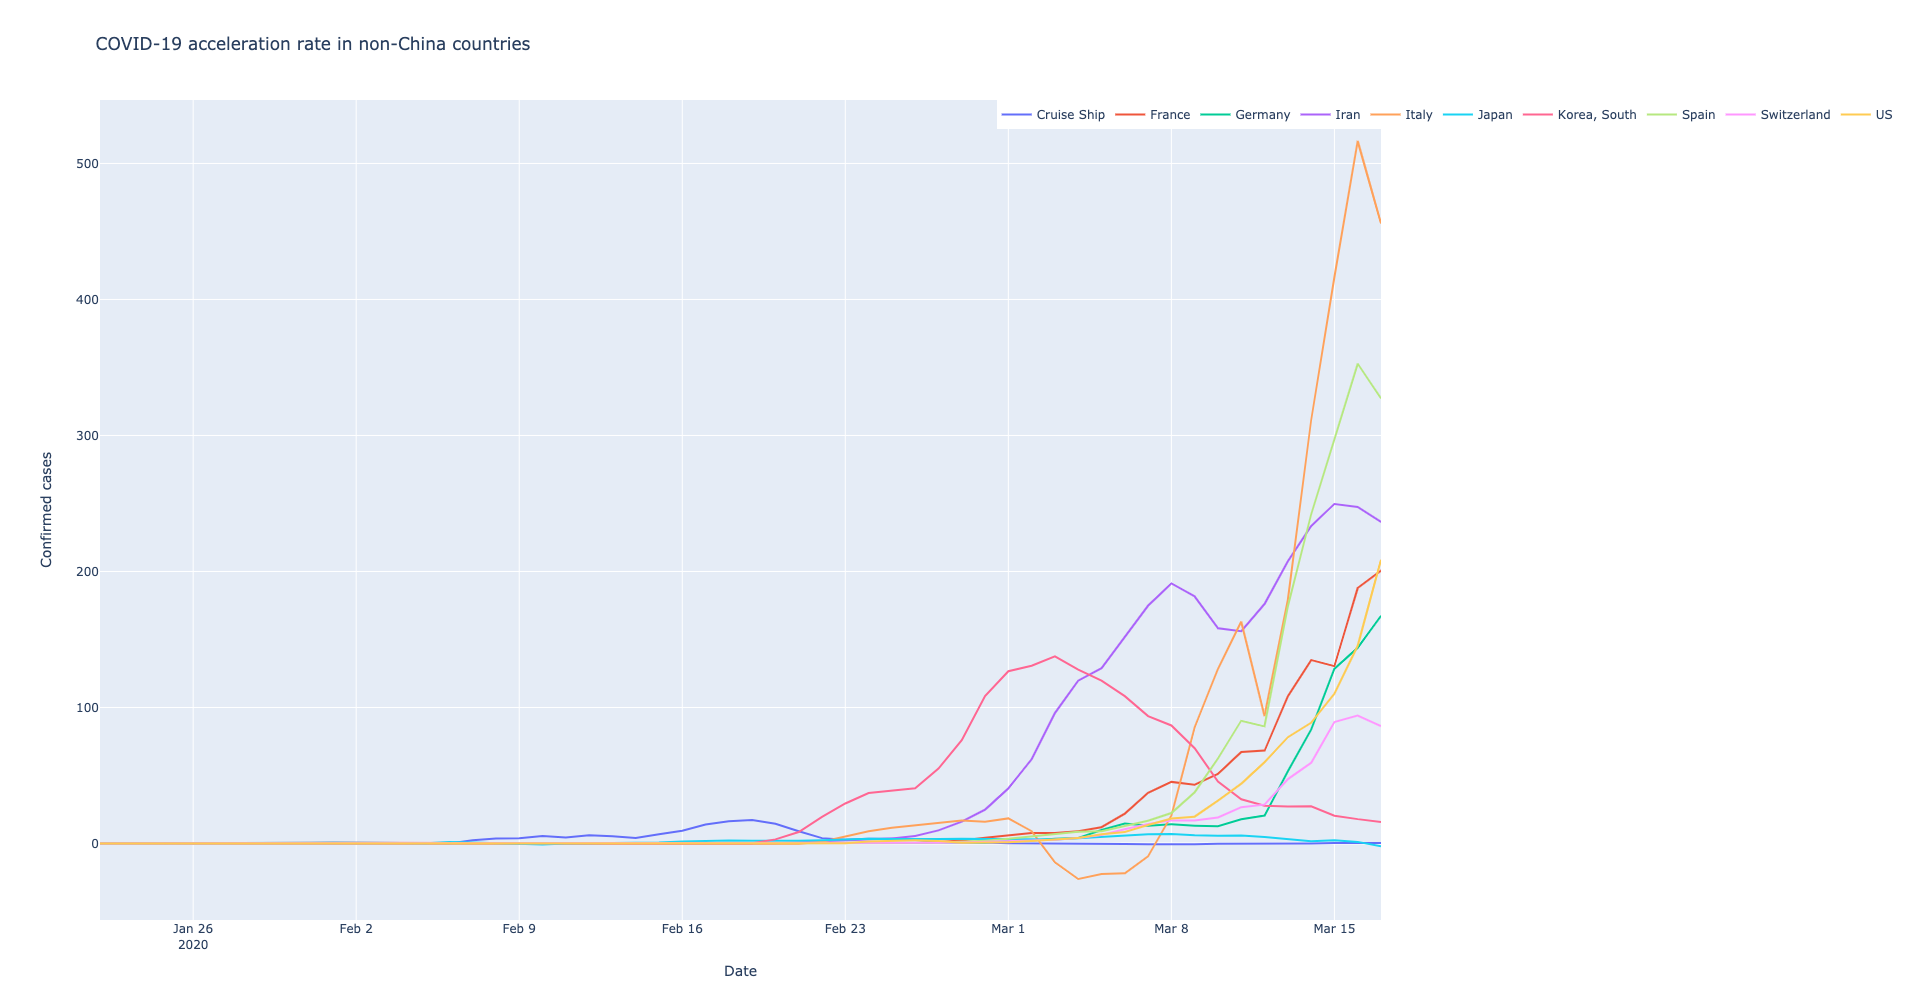

In [580]:
layout = go.Layout(title="COVID-19 acceleration rate in non-China countries", margin={"l": 100, "r": 100},
                   colorway=["#287D95", "#EF533B"], legend={"x": 0.7, "y": 1, 'orientation': "h"},
                   yaxis={'title': 'Confirmed cases'},
                   yaxis2={'title': 'Growth/Accel rate in cases', 'overlaying': 'y', 'side': 'right', "showgrid": False},
                   xaxis={"title": "Date"},
                   height=1000)

fig = go.Figure(data=traces_acceleration, layout=layout)
fig.show()